In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random


In [111]:
# Original Image
image1 = cv2.imread('WarpNet\images\original_image.png')
# resize image
image1 = cv2.resize(image1, (256, 256))

dir = r"WarpNet\images\old_image_textures"

# Randomly choose an image from dir
image2 = cv2.imread(os.path.join(dir, random.choice(os.listdir(dir))))
# resize image
image2 = cv2.resize(image2, (256, 256))


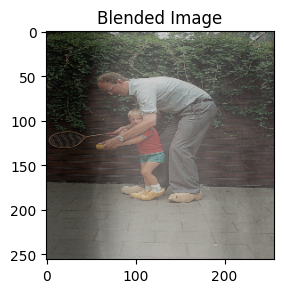

In [112]:
# Blend the images
alpha = 0.5
beta = 1 - alpha
blended = cv2.addWeighted(image1, alpha, image2, beta, 0)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title('Blended Image')
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))


In [113]:
# from PIL import Image
# import numpy as np
# import random
# import cv2
# from io import BytesIO
# from unstructured_noise import online_add_degradation,show_image, np_to_pil

In [114]:
from PIL import Image
import numpy as np
import random
import cv2
from io import BytesIO

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.

    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2, 0, 1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.


def np_to_pil(img_np):
    '''Converts image in np.array format to PIL image.

    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np * 255, 0, 255).astype(np.uint8)

    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def synthesize_salt_pepper(image,amount,salt_vs_pepper):

    ## Give PIL, return the noisy PIL

    img_pil=pil_to_np(image)

    out = img_pil.copy()
    p = amount
    q = salt_vs_pepper
    flipped = np.random.choice([True, False], size=img_pil.shape,
                               p=[p, 1 - p])
    salted = np.random.choice([True, False], size=img_pil.shape,
                              p=[q, 1 - q])
    peppered = ~salted
    out[flipped & salted] = 1
    out[flipped & peppered] = 0.
    noisy = np.clip(out, 0, 1).astype(np.float32)


    return np_to_pil(noisy)

def synthesize_gaussian(image,std_l,std_r):

    ## Give PIL, return the noisy PIL

    img_pil=pil_to_np(image)

    mean=0
    std=random.uniform(std_l/255.,std_r/255.)
    gauss=np.random.normal(loc=mean,scale=std,size=img_pil.shape)
    noisy=img_pil+gauss
    noisy=np.clip(noisy,0,1).astype(np.float32)

    return np_to_pil(noisy)

def synthesize_speckle(image,std_l,std_r):

    ## Give PIL, return the noisy PIL

    img_pil=pil_to_np(image)

    mean=0
    std=random.uniform(std_l/255.,std_r/255.)
    gauss=np.random.normal(loc=mean,scale=std,size=img_pil.shape)
    noisy=img_pil+gauss*img_pil
    noisy=np.clip(noisy,0,1).astype(np.float32)

    return np_to_pil(noisy)


def synthesize_low_resolution(img):
    w,h=img.size
    print(w, h)
    new_w=random.randint(int(w/2),w)
    new_h=random.randint(int(h/2),h)

    img=img.resize((new_w,new_h),Image.BICUBIC)

    if random.uniform(0,1)<0.5:
        img=img.resize((w,h),Image.NEAREST)
    else:
        img = img.resize((w, h), Image.BILINEAR)

    return img


def convertToJpeg(im,quality):
    with BytesIO() as f:
        im.save(f, format='JPEG',quality=quality)
        f.seek(0)
        return Image.open(f).convert('RGB')


def blur_image(img):
    x=np.array(img)
    kernel_size_candidate=[(3,3),(5,5),(7,7)]
    kernel_size=random.sample(kernel_size_candidate,1)[0]
    std=random.uniform(1.,5.)

    #print("The gaussian kernel size: (%d,%d) std: %.2f"%(kernel_size[0],kernel_size[1],std))
    blur=cv2.GaussianBlur(x,kernel_size,std)

    return Image.fromarray(blur.astype(np.uint8))

def online_add_degradation(img):

    task_id=np.random.permutation(3)

    for x in task_id:
        if x==0 and random.uniform(0,1)<0.7:
            img = blur_image(img)
        if x==1 and random.uniform(0,1)<0.7:
            flag = random.choice([1, 2, 3])
            if flag == 1:
                img = synthesize_gaussian(img, 5, 25)
            elif flag == 2:
                img = synthesize_speckle(img, 5, 25)
            elif flag == 3:
                img = synthesize_salt_pepper(img, random.uniform(0, 0.01), random.uniform(0.3, 0.5))
        if x==2 and random.uniform(0,1)<0.7:
            img=synthesize_low_resolution(img)

    return img



def show_image(title, image):
    cv2.imshow(title, cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [115]:
pil_image = Image.fromarray(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
show_image("", pil_image)

In [116]:
image = online_add_degradation(pil_image)
# Display the image
show_image("", image)


# Save the image
cv2.imwrite('WarpNet\images\\try.png',image)

256 256


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:703: error: (-215:Assertion failed) image.channels() == 1 || image.channels() == 3 || image.channels() == 4 in function 'cv::imwrite_'
